# 

# Сборный проект 2 - Прогноз уровня удовлетворенности сотрудника; Прогноз, что сотрудник уволится.
<a id='head'></a>

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Описание задач:

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Задача 1**: предсказание уровня удовлетворённости сотрудника.

**Шаг 1. Загрузка данных**

**Шаг 2. Предобработка данных**

**Шаг 3. Исследовательский анализ данных**

**Шаг 4. Подготовка данных**

**Шаг 5. Обучение моделей**

Обучение нескольких моделей. 

Основная метрика — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Метрика SMAPE вычисляется так:

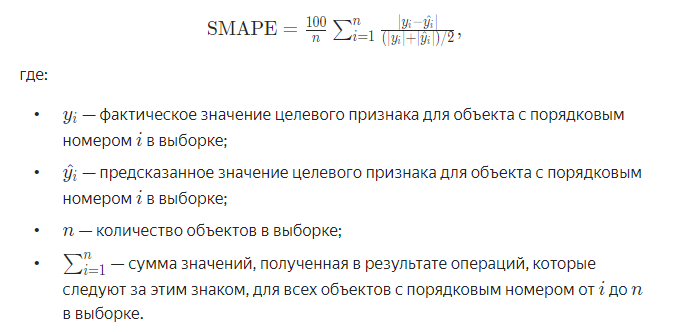

Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

**Шаг 6. Оформление выводов**

**Задача 2: предсказание увольнения сотрудника из компании**

Целевой признак - `quit` — увольнение сотрудника из компании.

**Шаг 1. Загрузка данных**

**Шаг 2. Предобработка данных**

**Шаг 3. Исследовательский анализ данных**

3.1. Исследовательский анализ данных.

3.2. Портрет «уволившегося сотрудника».

3.3. Проверка влияния уровеня удовлетворённости сотрудника работой в компании на то, уволится ли сотрудник.

**Шаг 4. Добавление нового входного признака**

**Шаг 5. Подготовка данных**

**Шаг 6. Обучение модели**
* Обучение как минимум трех моделей. 
* Метрика оценки качества в этой задаче — ROC-AUC. 
* Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке

**Шаг 7. Выводы**

## Загрузка библиотек

In [1]:
!pip install phik -q
!pip install scikit-learn --upgrade -q
!pip install shap -q
!pip install shap --upgrade -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pylab
import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)                                    
from sklearn.linear_model import (Lasso, Ridge, LogisticRegression)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier,
                          plot_tree)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import (SelectKBest, mutual_info_classif, f_classif)
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             make_scorer
                            )      
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   LabelEncoder
                                  )
from sklearn.impute import (KNNImputer, SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import (DummyClassifier, DummyRegressor)
                                    

import warnings
import re
import phik
import shap
import random
from tqdm import tqdm
import os

warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12, 6)})

pd.set_option('display.max_columns', None)

RANDOM_STATE = 15
TEST_SIZE = 0.25

DATA_PATH = '/datasets/'

## Прогноз значения удовлетворенности сотрудников

### Загрузка данных

In [3]:
train_jsr_df = pd.read_csv(os.path.join(DATA_PATH, 'train_job_satisfaction_rate.csv'))
test_features_df = pd.read_csv(os.path.join(DATA_PATH, 'test_features.csv'))
test_target_jsr_df = pd.read_csv(os.path.join(DATA_PATH, 'test_target_job_satisfaction_rate.csv'))

### Предобработка данных

In [4]:
train_jsr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [5]:
train_jsr_df.sort_values(by='id').head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


In [6]:
train_jsr_df['id'].duplicated().sum()

0

In [7]:
train_jsr_df[train_jsr_df['dept'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [8]:
train_jsr_df[train_jsr_df['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [9]:
train_jsr_df['dept'].value_counts(dropna=False)

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
NaN              6
Name: dept, dtype: int64

In [10]:
train_jsr_df['level'].value_counts(dropna=False)

junior    1894
middle    1744
sinior     358
NaN          4
Name: level, dtype: int64

In [11]:
train_jsr_df['level'] = train_jsr_df['level'].str.replace('sinior', 'senior')

In [12]:
train_jsr_df['workload'].value_counts(dropna=False)

medium    2066
low       1200
high       734
Name: workload, dtype: int64

In [13]:
train_jsr_df['last_year_promo'].value_counts(dropna=False)

no     3880
yes     120
Name: last_year_promo, dtype: int64

In [14]:
train_jsr_df['last_year_violations'].value_counts(dropna=False)

no     3441
yes     559
Name: last_year_violations, dtype: int64

In [15]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [16]:
test_features_df.sort_values(by='id')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000
...,...,...,...,...,...,...,...,...,...
1925,997290,sales,sinior,medium,7,no,no,4,58800
1886,998548,marketing,junior,medium,2,no,no,4,32400
506,998762,technology,junior,low,3,no,no,3,22800
1579,998900,marketing,middle,medium,7,no,no,3,45600


In [17]:
test_features_df['id'].duplicated().sum()

0

In [18]:
test_features_df['dept'].value_counts(dropna=False)

sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN             2
                1
Name: dept, dtype: int64

In [19]:
test_features_df['level'].value_counts(dropna=False)

junior    974
middle    854
sinior    171
NaN         1
Name: level, dtype: int64

In [20]:
test_features_df['level'] = test_features_df['level'].str.replace('sinior', 'senior')

In [21]:
test_features_df['workload'].value_counts(dropna=False)

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [22]:
test_features_df[test_features_df['workload'] == ' '] 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [23]:
test_features_df['last_year_promo'].value_counts(dropna=False)

no     1937
yes      63
Name: last_year_promo, dtype: int64

In [24]:
test_features_df['last_year_violations'].value_counts(dropna=False)

no     1738
yes     262
Name: last_year_violations, dtype: int64

In [25]:
test_features_df[test_features_df['dept'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [26]:
test_features_df[test_features_df['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [27]:
test_target_jsr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [28]:
test_target_jsr_df.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [29]:
test_target_jsr_df['id'].duplicated().sum()

0

- в двух датасетах `train_jsr_df` и `test_features_df` есть пропуски и пустые значения. Заполнять буду в пайплайне.
- признаки имеют соответствующие типы данных.

### Исследовательский анализ данных

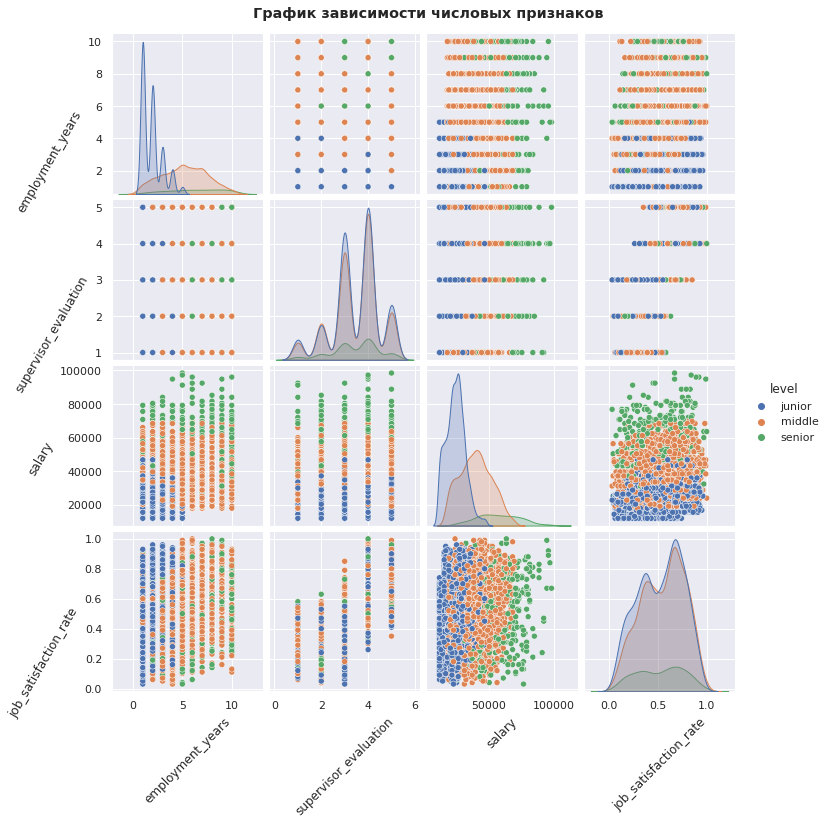

In [30]:
corr_plot = sns.pairplot(train_jsr_df.drop(columns='id'), diag_kind='kde', hue='level')

for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)
    
plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

Корреляции между признаками нет, кроме двух признаков job_satisfaction_rate и supervisor_evaluation. Видно категориальные данные supervisor_evaluation и employment_years.

In [31]:
def numeric_analysis(df, column, annot):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])
    
    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')
    
    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')
    plt.show()

In [32]:
train_jsr_df.select_dtypes(include='number').columns.tolist()


['id',
 'employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Верхний ус: 12.0 
Нижний ус: -4.0     
Медианное значение: 3.0


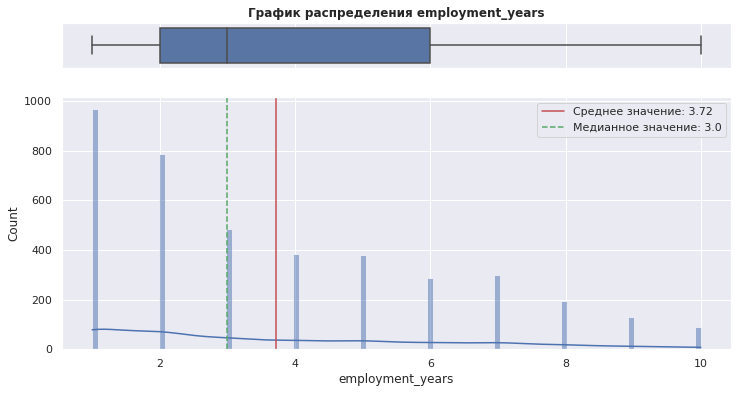

In [33]:
numeric_analysis(train_jsr_df, 'employment_years', 'employment_years')

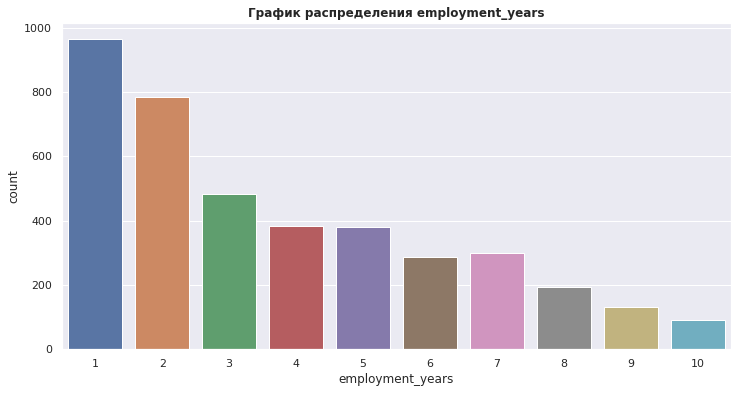

In [34]:
sns.countplot(data=train_jsr_df, x='employment_years')
plt.title('График распределения employment_years', weight='bold')
plt.show()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Верхний ус: 5.5 
Нижний ус: 1.5     
Медианное значение: 4.0


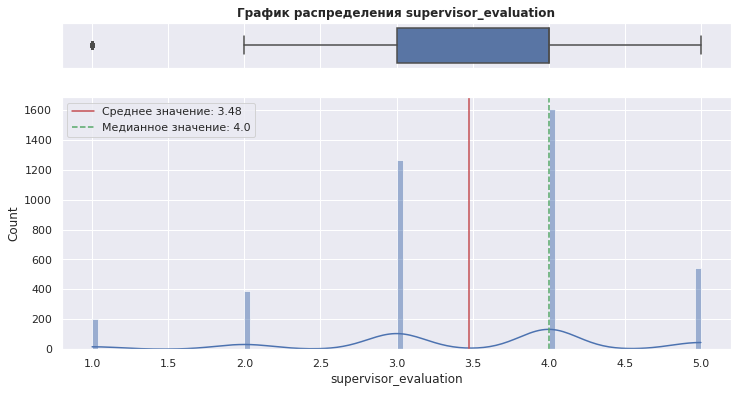

In [35]:
numeric_analysis(train_jsr_df, 'supervisor_evaluation', 'supervisor_evaluation')

- Данный признак лучше всего закодировать OrdinalEncoder, так как оценка это ранговое значение.

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Верхний ус: 73800.0 
Нижний ус: -7800.0     
Медианное значение: 30000.0


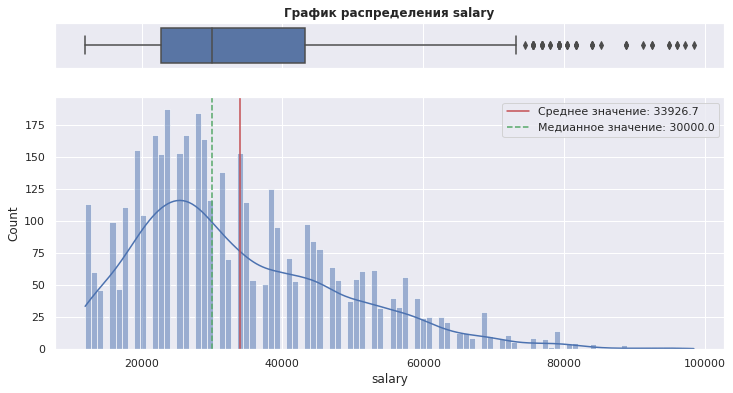

In [36]:
numeric_analysis(train_jsr_df, 'salary', 'salary')

In [37]:
train_jsr_df[train_jsr_df['salary'] > 73800].count()

id                       60
dept                     60
level                    60
workload                 60
employment_years         60
last_year_promo          60
last_year_violations     60
supervisor_evaluation    60
salary                   60
job_satisfaction_rate    60
dtype: int64

- 60 человек имеют выброс по зарплате. Это сеньоры. Можно добавить новый признак с тремя, четырьмя уровнями зарплаты.

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

Верхний ус: 1.23 
Нижний ус: -0.16     
Медианное значение: 0.56


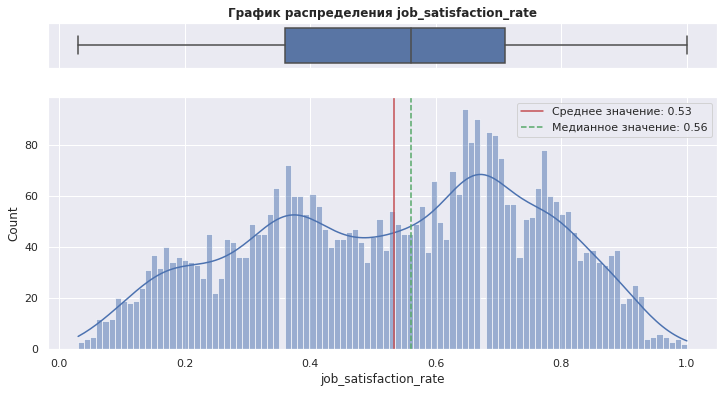

In [38]:
numeric_analysis(train_jsr_df, 'job_satisfaction_rate', 'job_satisfaction_rate')

Судя по графику целевого признака, сотрудников можно разделить на три группы риска на уход из компании. 

In [39]:
train_jsr_df.select_dtypes(exclude='number').columns.tolist()

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [40]:
def cat_vis(df, cat):
    buyers_activity_grouped = df.groupby(cat)['id'].agg('count')
    sns.barplot(x=df[cat].value_counts(), 
                y=df[cat].value_counts().index, 
                data=df,
               )
    plt.title(f'График распределения {cat}', weight='bold')
    plt.xlabel('Кол-во сотрудников')
    plt.show()

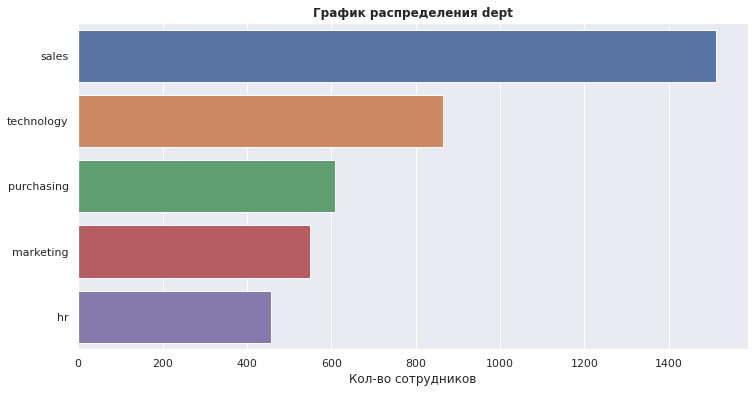

In [41]:
cat_vis(train_jsr_df, 'dept')

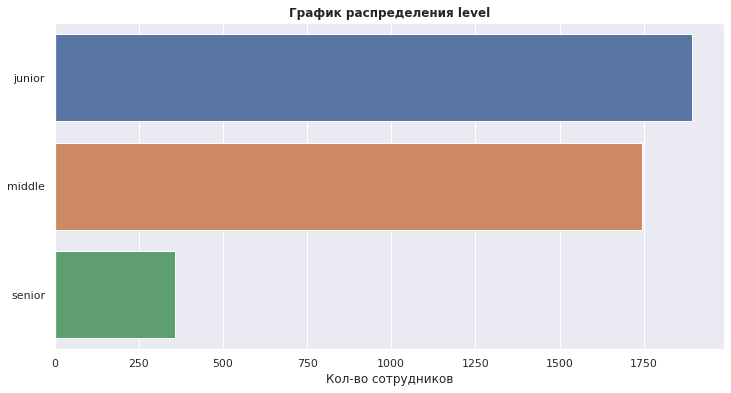

In [42]:
cat_vis(train_jsr_df, 'level')

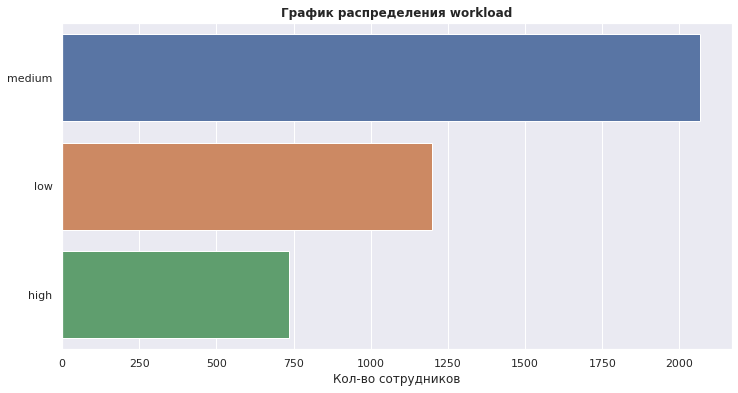

In [43]:
cat_vis(train_jsr_df, 'workload')

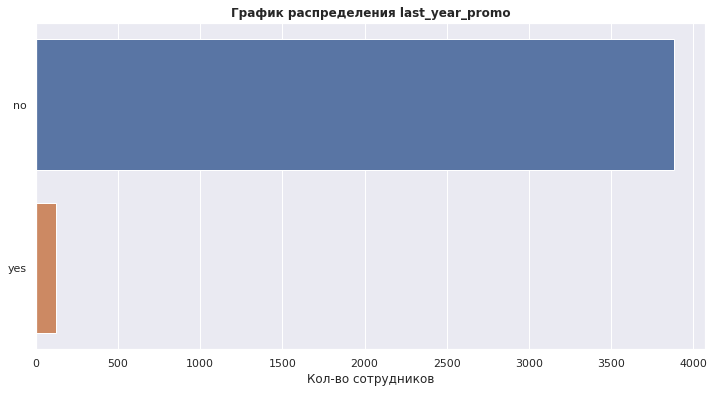

In [44]:
cat_vis(train_jsr_df, 'last_year_promo')

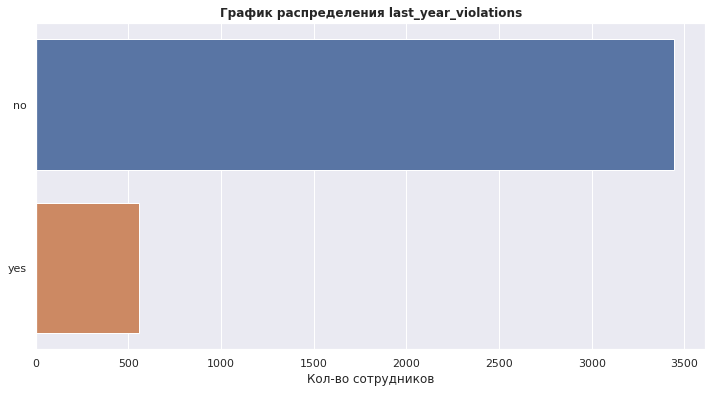

In [45]:
cat_vis(train_jsr_df, 'last_year_violations')

В категориальных данных присутствует дисбаланс классов. Для первой части задания, а именно опредление уровня удоволетворенности сотрудников, устранение дисбаланса можно пропустить. 

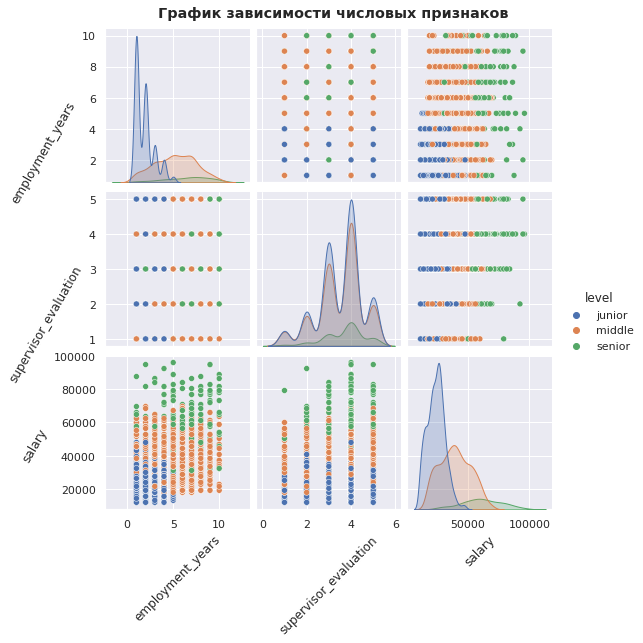

In [46]:
corr_plot = sns.pairplot(test_features_df.drop(columns='id'), diag_kind='kde', hue='level')
for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)
    
plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Верхний ус: 13.5 
Нижний ус: -6.5     
Медианное значение: 3.0


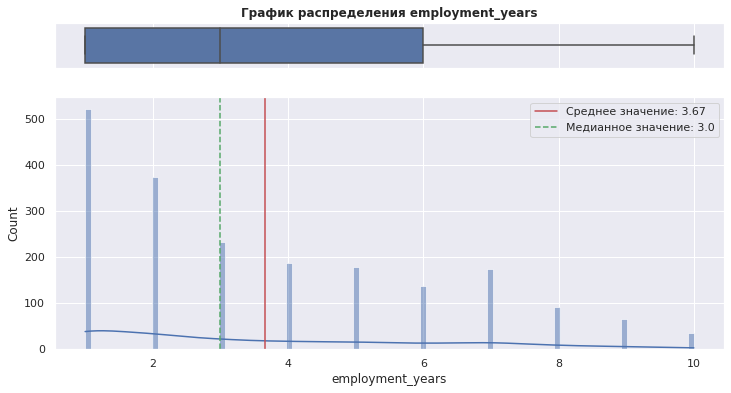

In [47]:
numeric_analysis(test_features_df, 'employment_years', 'employment_years')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Верхний ус: 73800.0 
Нижний ус: -7800.0     
Медианное значение: 30000.0


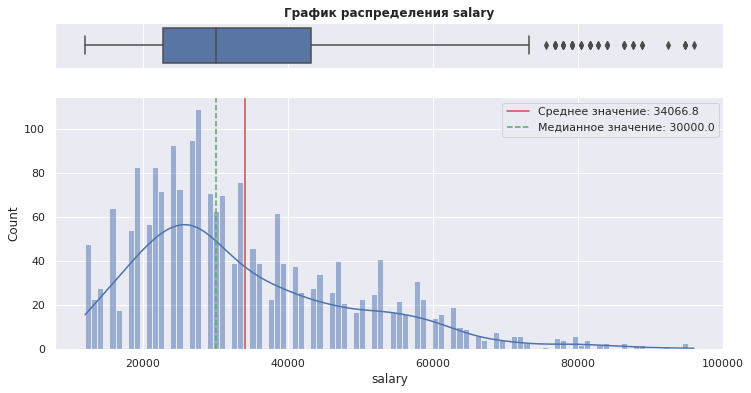

In [48]:
numeric_analysis(test_features_df, 'salary', 'salary')

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Верхний ус: 5.5 
Нижний ус: 1.5     
Медианное значение: 4.0


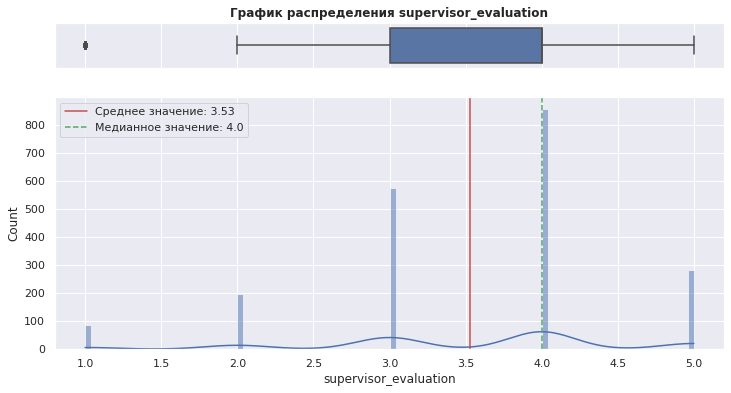

In [49]:
numeric_analysis(test_features_df, 'supervisor_evaluation', 'supervisor_evaluation')

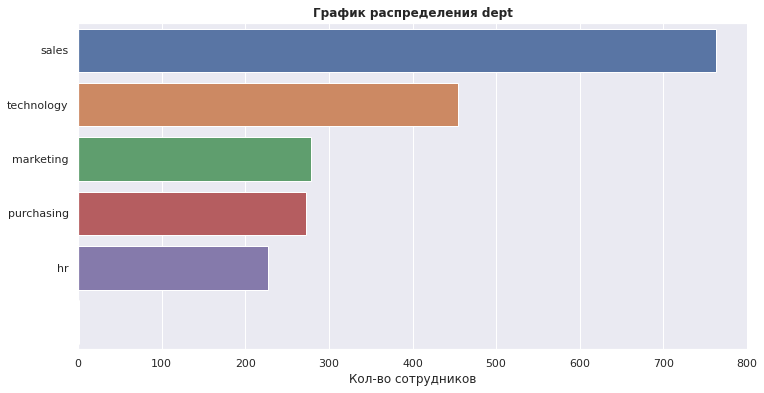

In [50]:
cat_vis(test_features_df, 'dept')

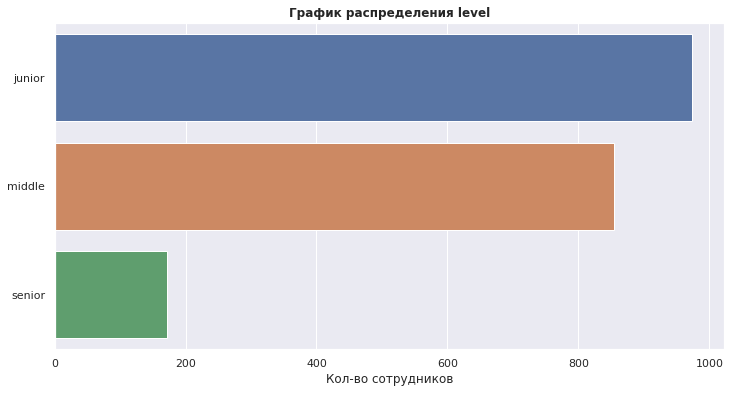

In [51]:
cat_vis(test_features_df, 'level')

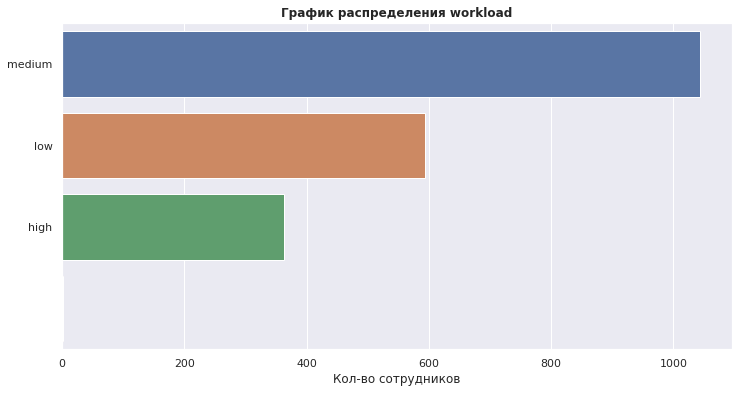

In [52]:
cat_vis(test_features_df, 'workload')

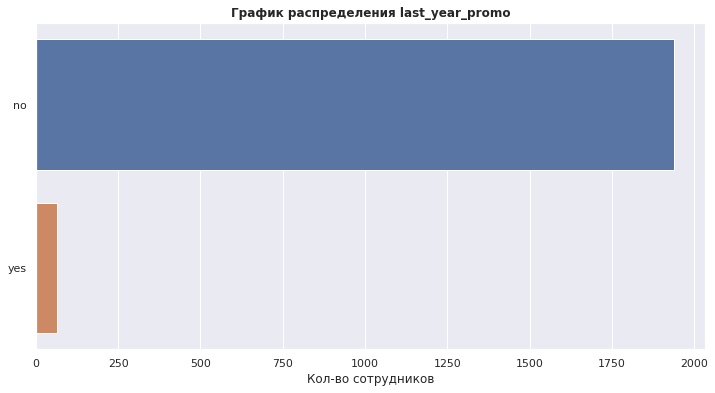

In [53]:
cat_vis(test_features_df, 'last_year_promo')

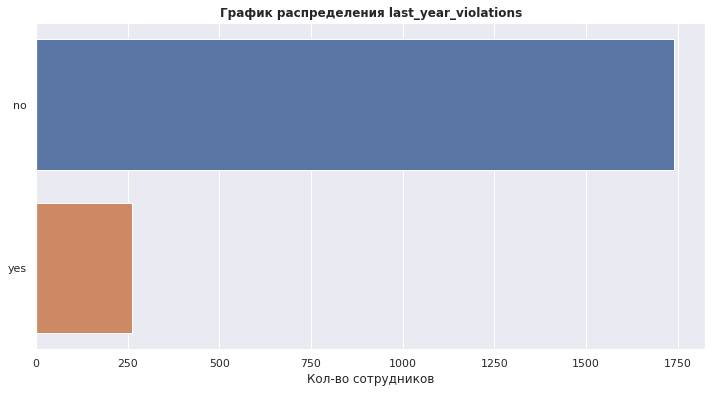

In [54]:
cat_vis(test_features_df, 'last_year_violations')

График показвает, что датасет с тестовыми признаками имеет похожую картину, как у тренировочного датасета.

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

Верхний ус: 1.23 
Нижний ус: -0.13     
Медианное значение: 0.58


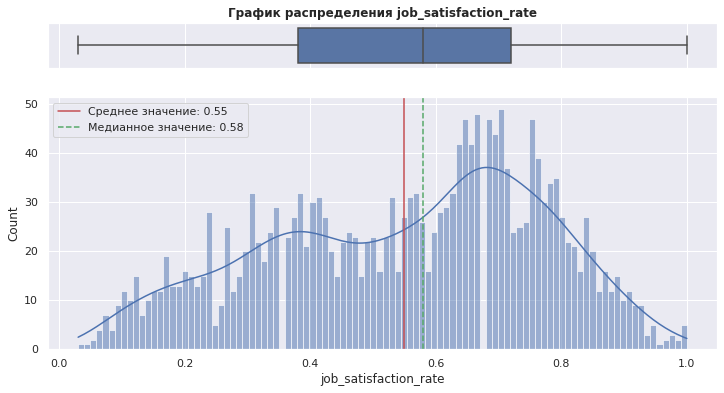

In [55]:
numeric_analysis(test_target_jsr_df, 'job_satisfaction_rate', 'job_satisfaction_rate')

- Для корректной работы интервальные признаки (`employment_years`, `salary`) нужно отмасштабировать.
- Признак `supervisor_evaluation` уже закодирован, поэтому его можно не изменять.
- Категориальные признаки нужно закодировать. При этом признак `level` нужно кодировать с учетом ранга.

### Создание кастомной метрики

In [56]:
def smape(y_true, y_pred):
    score = 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    
    return score

smape_score = make_scorer(smape, greater_is_better=False)

### Добавление новых признаков

In [57]:
train_jsr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [58]:
median = train_jsr_df['salary'].median()
def salary_categorization(x, residual):
    if x <= median:
        return '1 группа'
    elif median < x <= residual:
        return '2 группа'
    else:
        return '3 группа'

In [59]:
test_features_df['salary_category'] = test_features_df['salary'].apply(salary_categorization, args=(73800,))

In [60]:
train_jsr_df['salary_category'] = train_jsr_df['salary'].apply(salary_categorization, args=(73800,))
train_jsr_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_category
0,155278,sales,junior,medium,2,no,no,1,24000,0.58,1 группа
1,653870,hr,junior,high,2,no,no,5,38400,0.76,2 группа
2,184592,sales,junior,low,1,no,no,2,12000,0.11,1 группа
3,171431,technology,junior,low,4,no,no,2,18000,0.37,1 группа
4,693419,hr,junior,medium,1,no,no,3,22800,0.20,1 группа


In [61]:
train_jsr_df['log_salary'] = np.log1p(train_jsr_df['salary'])
test_features_df['log_salary'] = np.log1p(test_features_df['salary'])

count    4000.000000
mean       10.338474
std         0.435711
min         9.392745
25%        10.034560
50%        10.308986
75%        10.673619
max        11.496806
Name: log_salary, dtype: float64

Верхний ус: 11.63 
Нижний ус: 9.08     
Медианное значение: 10.308985993422082


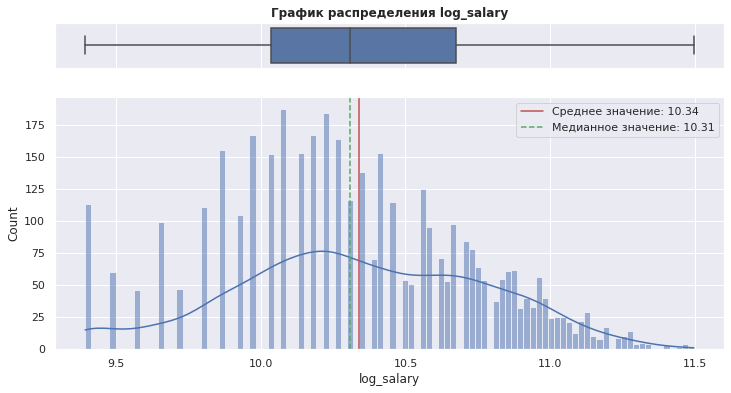

In [62]:
numeric_analysis(train_jsr_df, 'log_salary', 'log_salary')

### Корреляционные анализ

In [63]:
train_jsr_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,salary_category,log_salary
0,155278,sales,junior,medium,2,no,no,1,24000,0.58,1 группа,10.085851
1,653870,hr,junior,high,2,no,no,5,38400,0.76,2 группа,10.555839
2,184592,sales,junior,low,1,no,no,2,12000,0.11,1 группа,9.392745
3,171431,technology,junior,low,4,no,no,2,18000,0.37,1 группа,9.798183
4,693419,hr,junior,medium,1,no,no,3,22800,0.20,1 группа,10.034560


In [64]:
corr = train_jsr_df.drop(columns='id').phik_matrix(interval_cols=['employment_years', 'salary', 'job_satisfaction_rate', 'log_salary'])

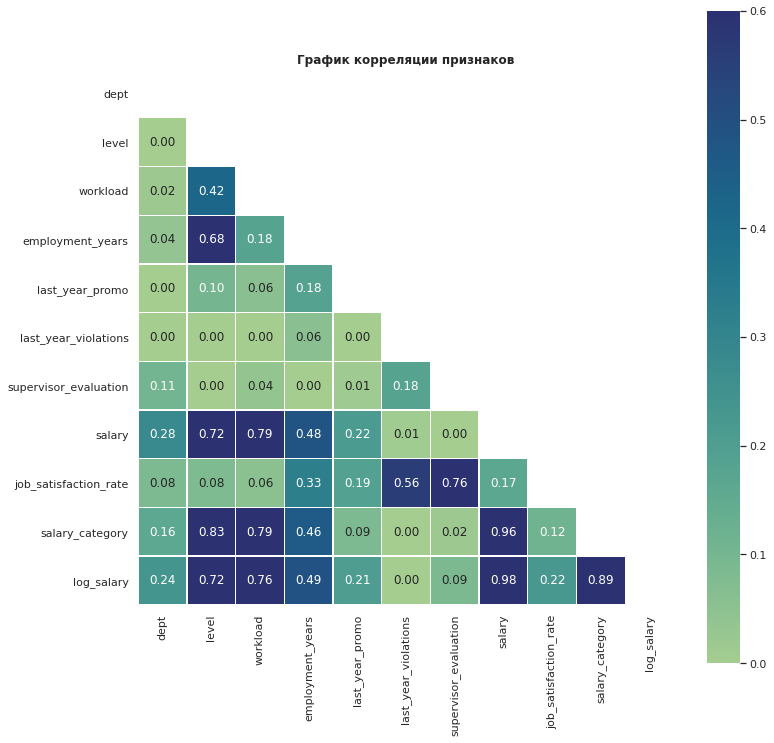

In [65]:
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, mask=mask, 
            square=True, 
            linewidths=.3,
            vmax=0.6,
        
            annot=True, 
            cmap=cmap, 
            fmt='.2f')

plt.title('График корреляции признаков', weight='bold')
plt.show()

Сильная корреляции признаков:
* `salary_category` - `salary`
* `log_salary` - `salary`
* `salary_category` - `log_salary`

### Подготовка данных и обучение модели

In [66]:
X_train = train_jsr_df.drop(columns=['id', 'job_satisfaction_rate'])
y_train = train_jsr_df['job_satisfaction_rate']

In [67]:
X_train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'salary_category', 'log_salary'],
      dtype='object')

In [68]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'salary_category']
num_columns = ['employment_years', 'salary', 'log_salary']

In [69]:
#пайплайн кодирования категориального признака
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'SimpleImputer_ohe', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [70]:
#пайплайн кодирования категориального рангового признака
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_ord_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'SimpleImputer_ord', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[['junior', 'middle', 'senior'],
                            ['low', 'medium', 'high'],
                            ['1 группа', '2 группа', '3 группа']
                           ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
    ]
) 

In [71]:
#сбор кодировщиков и скейлеров
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [72]:
#финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [73]:
param_grid = [
    # словарь для модели Lasso() 
    {
        # название модели
        'models': [Lasso(random_state=RANDOM_STATE)],
        # указываем гиперпараметр модели n_neighbors
        'models__alpha': [0.001, 0.01, 0.1, 1, 10],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели Ridge() 
    {
        # название модели
        'models': [Ridge(random_state=RANDOM_STATE)],
        # указываем гиперпараметр модели n_neighbors
        'models__alpha': [0.001, 0.01, 0.1, 1, 10],
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(1, 50, 2),
        'preprocessor__num': ['passthrough']
    }
] 

In [74]:
rndscv = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring=smape_score,
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

### Проверка работы модели

In [75]:
rndscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_ohe',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                         'models__alpha': [0.001, 0.01, 0.1, 1,
                                                           10],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeRegressor(random_state=15)],
                                         'models__max_depth': range(2, 20),
                                         'models__min_samples_leaf': range(1, 50, 2),
                                         'preprocessor__num': ['passthrough']}],
                   random_state=15,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [76]:
pd.DataFrame(rndscv.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_leaf,param_models__max_depth,param_models,param_models__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034872,0.000796,0.014344,0.000188,passthrough,5.0,19.0,DecisionTreeRegressor(random_state=15),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-14.980265,-14.766853,-15.018435,-15.149047,-13.988635,-14.780647,0.414628,1
8,0.031863,0.000393,0.013522,0.000567,passthrough,1.0,8.0,DecisionTreeRegressor(random_state=15),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-17.419203,-16.175078,-16.849554,-17.195947,-16.756188,-16.879194,0.425142,2
9,0.031634,0.000943,0.013175,0.000172,passthrough,23.0,11.0,DecisionTreeRegressor(random_state=15),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-17.680695,-16.634452,-17.344146,-17.103500,-15.634614,-16.879481,0.709616,3
6,0.030771,0.000526,0.013064,0.000261,passthrough,25.0,9.0,DecisionTreeRegressor(random_state=15),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-17.981764,-16.991347,-17.651740,-17.258538,-16.365020,-17.249682,0.556244,4
4,0.030700,0.000549,0.013292,0.000565,passthrough,19.0,7.0,DecisionTreeRegressor(random_state=15),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-18.564997,-17.610339,-17.867116,-17.820858,-17.282731,-17.829208,0.421766,5


In [77]:
X_test = test_features_df.sort_values(by='id')
best_model = rndscv.best_estimator_
pred_y = best_model.predict(X_test)

In [78]:
pred_y

array([0.85      , 0.852     , 0.79      , ..., 0.48888889, 0.46333333,
       0.30714286])

In [79]:
y_test = test_target_jsr_df.sort_values(by='id')
round(smape(y_test['job_satisfaction_rate'], pred_y), 2)

13.34

In [80]:
dummy_model_regres = DummyRegressor()
dummy_model_regres.fit(X_train, y_train)

DummyRegressor()

In [81]:
dummy_regres_y = dummy_model_regres.predict(X_test)
round(smape(y_test['job_satisfaction_rate'], dummy_regres_y), 2)

38.22

In [82]:
residuals_model = y_test['job_satisfaction_rate'] - pred_y
residuals_model.describe()

count    2000.000000
mean       -0.000740
std         0.073856
min        -0.278000
25%        -0.048571
50%        -0.002000
75%         0.046000
max         0.298889
Name: job_satisfaction_rate, dtype: float64

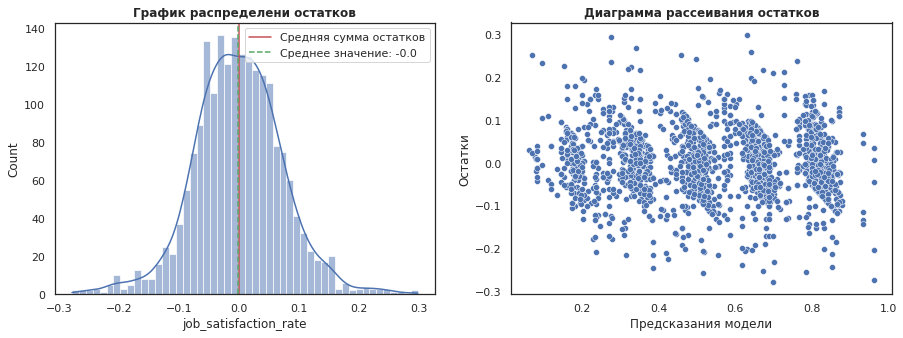

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(residuals_model, bins=50, kde=True, ax=axes[0])
axes[0].set_title('График распределени остатков', weight='bold')
axes[0].axvline(0, color='r', linestyle='-', label=f'Средняя сумма остатков')
axes[0].axvline(residuals_model.mean(), color='g', linestyle='--', label=f'Среднее значение: {round(residuals_model.mean(), 2)}')
axes[0].legend(loc='best')
sns.scatterplot(x=pred_y, y=residuals_model)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Диаграмма рассеивания остатков', weight='bold')
plt.show()

Остатки группируются в пять групп. Скорее всего это связано с кол-ом отделов в организации или оценками сотрудников.

stat:0.99, p:0.0
Распределение не нормальное


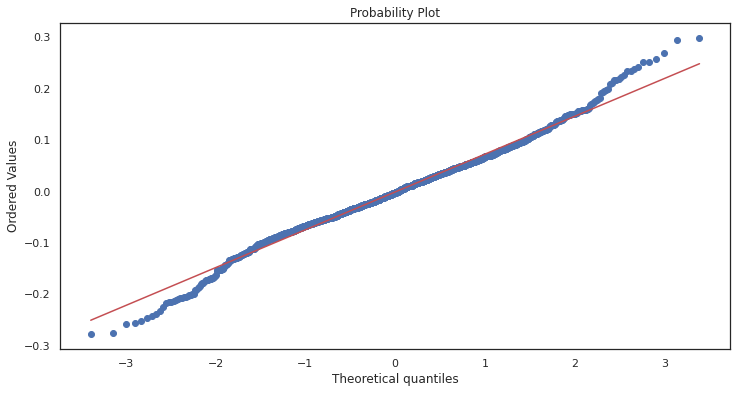

In [84]:
def norm_check(df):
    stat, p = shapiro(df)
    print(f'stat:{round(stat, 3)}, p:{round(p, 6)}')
    if p > 0.05:
        print('Распределние нормальное')
    else:
        print('Распределение не нормальное')

    stats.probplot(df, dist='norm', plot=pylab)
    pylab.show()
    
norm_check(residuals_model)

In [85]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

In [86]:
feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model.named_steps['models'].feature_importances_
    }) 

In [87]:
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
12,remainder__supervisor_evaluation,0.682950
9,num__employment_years,0.074449
5,ohe__last_year_violations_yes,0.051528
6,ord__level,0.047496
10,num__salary,0.046313
11,num__log_salary,0.034397
7,ord__workload,0.018350
2,ohe__dept_sales,0.012684
4,ohe__last_year_promo_yes,0.010381
0,ohe__dept_marketing,0.009350


In [88]:
rndscv.best_params_

{'preprocessor__num': 'passthrough',
 'models__min_samples_leaf': 5,
 'models__max_depth': 19,
 'models': DecisionTreeRegressor(random_state=15)}

- Лучшая модель DecisionTreeRegressor(max_depth=19, min_samples_leaf=5, random_state=15).
- SMAPE = 13.34.
- Тройка самых выжных признаков `supervisor_evaluation`, `employment_years` и `last_year_violations`.
- Основная модель показывает лучший результат (13.34) по сравнению с базовой (38.22). Тест на адекватность пройден.

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [89]:
train_quit_df = pd.read_csv(os.path.join(DATA_PATH, 'train_quit.csv'))
test_quit_features_df = pd.read_csv(os.path.join(DATA_PATH, 'test_features.csv'))
test_target_quit_df = pd.read_csv(os.path.join(DATA_PATH, 'test_target_quit.csv'))

### Предобработка данных

In [90]:
train_quit_df.sort_values(by='id', inplace=True)
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [91]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2600 to 2120
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


In [92]:
train_quit_df['id'].duplicated().sum()

0

In [93]:
train_quit_df['dept'].value_counts(dropna=False)

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

In [94]:
train_quit_df['level'].value_counts(dropna=False)

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

In [95]:
train_quit_df['level'] = train_quit_df['level'].str.replace('sinior', 'senior')

In [96]:
train_quit_df['workload'].value_counts(dropna=False)

medium    2118
low       1208
high       674
Name: workload, dtype: int64

In [97]:
train_quit_df['last_year_promo'].value_counts(dropna=False)

no     3887
yes     113
Name: last_year_promo, dtype: int64

In [98]:
train_quit_df['last_year_violations'].value_counts(dropna=False)

no     3455
yes     545
Name: last_year_violations, dtype: int64

In [99]:
train_quit_df['quit'].value_counts(dropna=False)

no     2872
yes    1128
Name: quit, dtype: int64

In [100]:
test_quit_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [101]:
test_quit_features_df['id'].duplicated().sum()

0

In [102]:
test_quit_features_df['dept'].value_counts(dropna=False)

sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN             2
                1
Name: dept, dtype: int64

In [103]:
test_quit_features_df['level'].value_counts(dropna=False)

junior    974
middle    854
sinior    171
NaN         1
Name: level, dtype: int64

In [104]:
test_quit_features_df['level'] = test_quit_features_df['level'].str.replace('sinior', 'senior')

In [105]:
test_quit_features_df['workload'].value_counts(dropna=False)

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

In [106]:
test_quit_features_df['last_year_promo'].value_counts(dropna=False)

no     1937
yes      63
Name: last_year_promo, dtype: int64

In [107]:
test_quit_features_df.sort_values(by='id', inplace=True)

В данных есть NaN зачения и пустые значения где стоит пробел. Пробелы обработаю в пайплайне.

In [108]:
test_target_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [109]:
test_target_quit_df['id'].duplicated().sum()

0

In [110]:
test_target_quit_df['quit'].value_counts(dropna=False)

no     1436
yes     564
Name: quit, dtype: int64

In [111]:
test_target_quit_df.sort_values(by='id', inplace=True)

### Исследовательский анализ

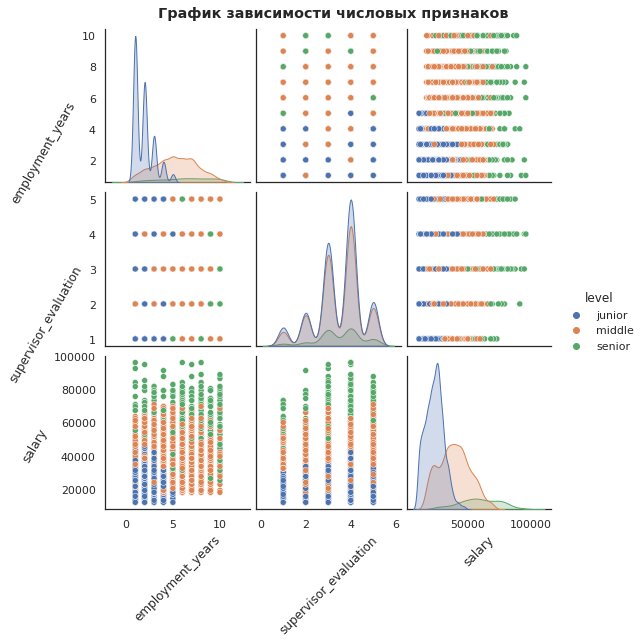

In [112]:
corr_plot = sns.pairplot(train_quit_df.drop(columns='id'), diag_kind='kde', hue='level')
for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)
    
plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

In [113]:
test_target_quit_df.sort_values(by='id', inplace=True)
test_target_quit_df.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Верхний ус: 12.0 
Нижний ус: -4.0     
Медианное значение: 3.0


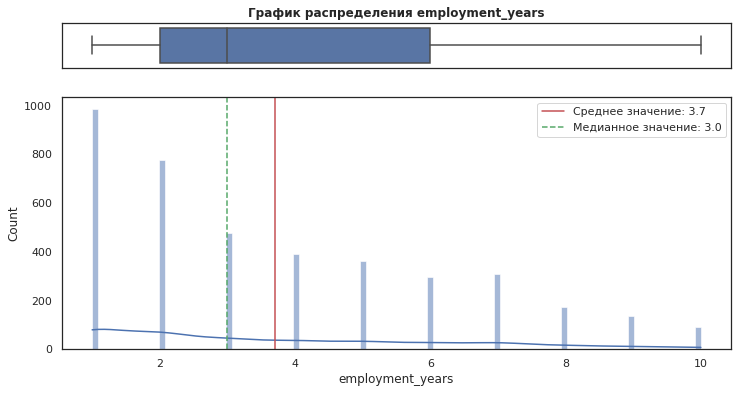

In [114]:
numeric_analysis(train_quit_df, 'employment_years', 'employment_years')

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Верхний ус: 73800.0 
Нижний ус: -7800.0     
Медианное значение: 30000.0


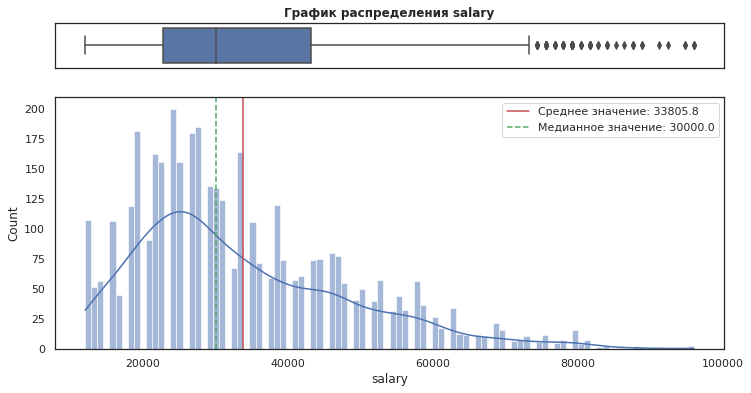

In [115]:
numeric_analysis(train_quit_df, 'salary', 'salary')

Присутствуют выбросы, но это зарплата сеньоров, поэтому ничего удивительного в этом нет.

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Верхний ус: 5.5 
Нижний ус: 1.5     
Медианное значение: 4.0


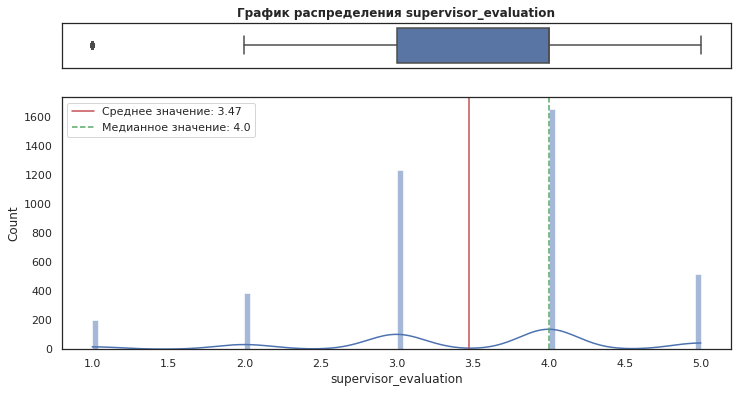

In [116]:
numeric_analysis(train_quit_df, 'supervisor_evaluation', 'supervisor_evaluation')

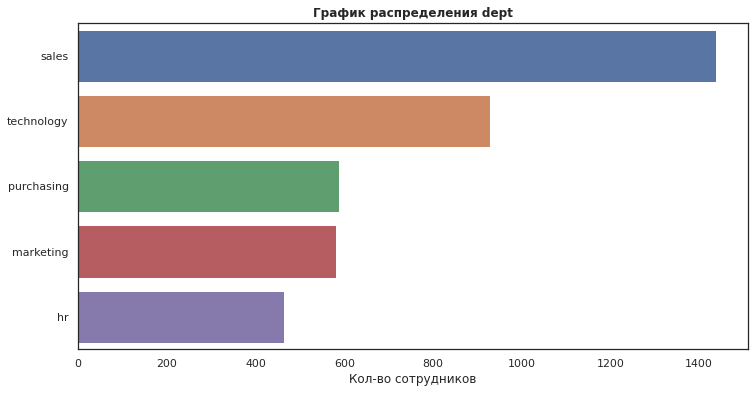

In [117]:
cat_vis(train_quit_df, 'dept')

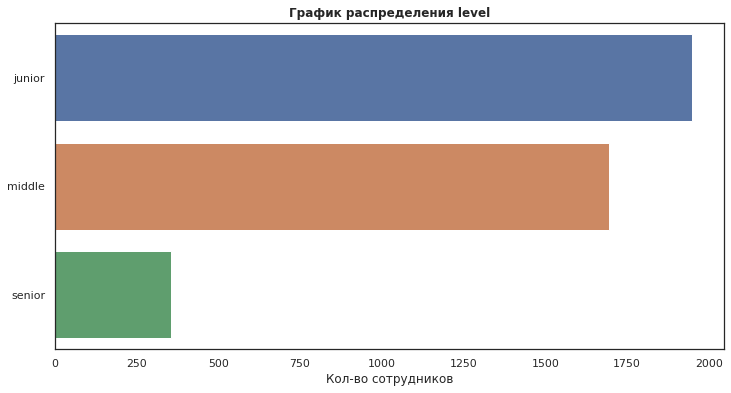

In [118]:
cat_vis(train_quit_df, 'level')

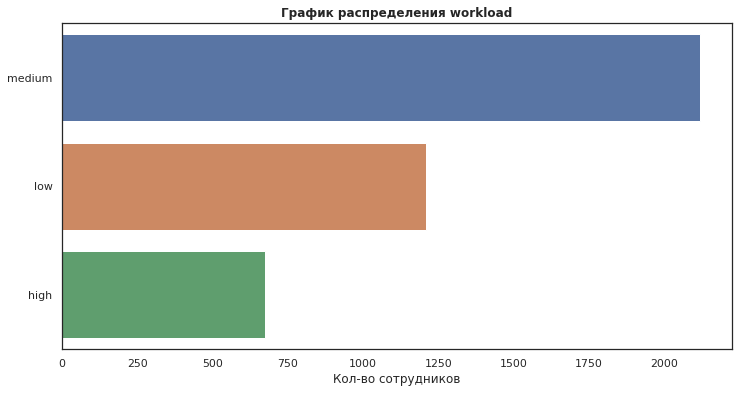

In [119]:
cat_vis(train_quit_df, 'workload')

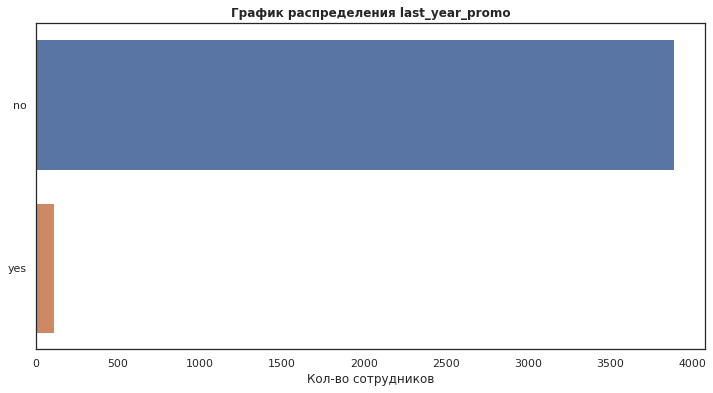

In [120]:
cat_vis(train_quit_df, 'last_year_promo')

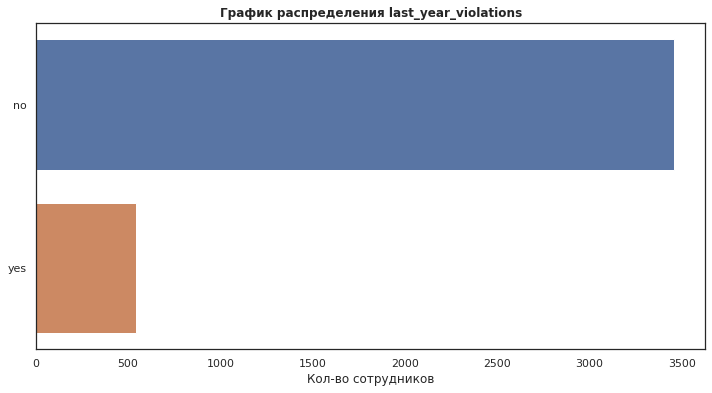

In [121]:
cat_vis(train_quit_df, 'last_year_violations')

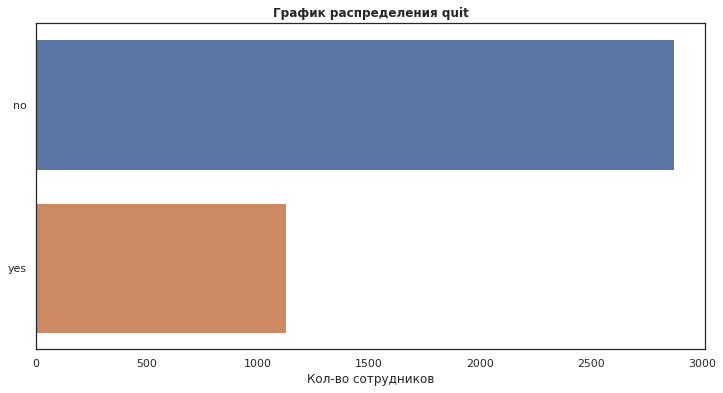

In [122]:
cat_vis(train_quit_df, 'quit')

Присутствует дисбаланс целевого признака.

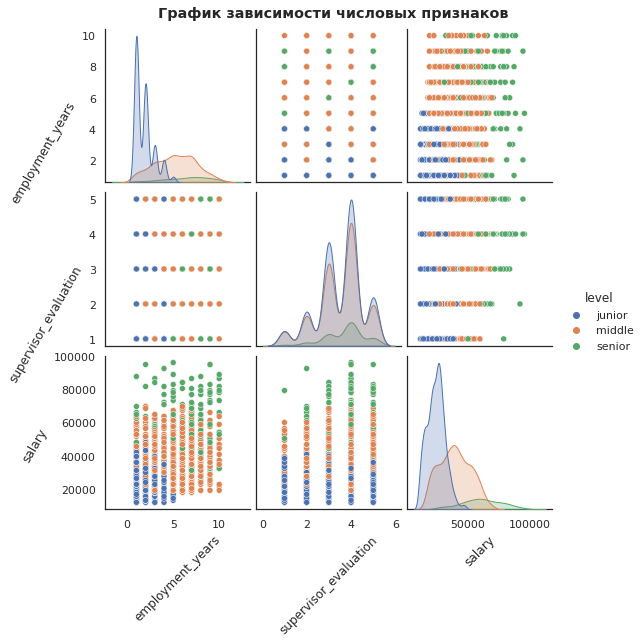

In [123]:
corr_plot = sns.pairplot(test_quit_features_df.drop(columns='id'), diag_kind='kde', hue='level')
for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)

plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

Верхний ус: 13.5 
Нижний ус: -6.5     
Медианное значение: 3.0


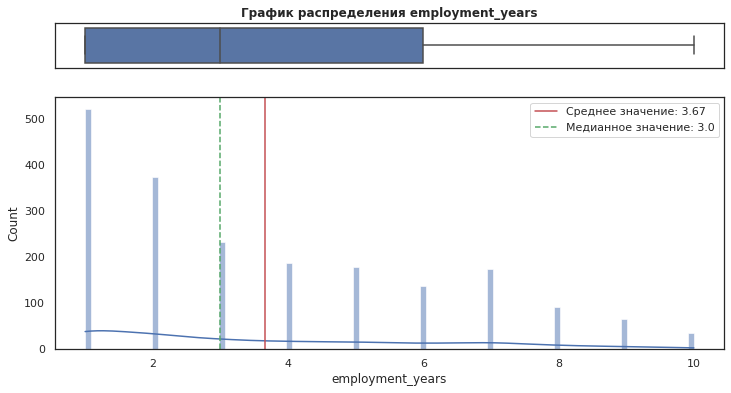

In [124]:
numeric_analysis(test_quit_features_df, 'employment_years', 'employment_years')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

Верхний ус: 73800.0 
Нижний ус: -7800.0     
Медианное значение: 30000.0


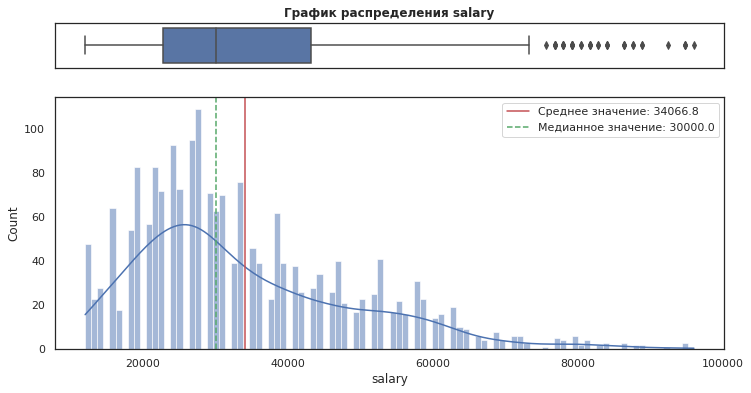

In [125]:
numeric_analysis(test_quit_features_df, 'salary', 'salary')

Аналогично с тренировочными данными есть выбросы по зарплате, но это зарплата сеньоров.

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

Верхний ус: 5.5 
Нижний ус: 1.5     
Медианное значение: 4.0


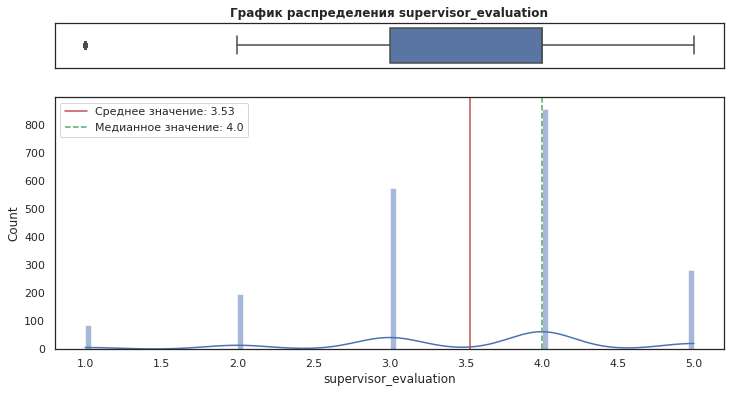

In [126]:
numeric_analysis(test_quit_features_df, 'supervisor_evaluation', 'supervisor_evaluation')

In [127]:
test_quit_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


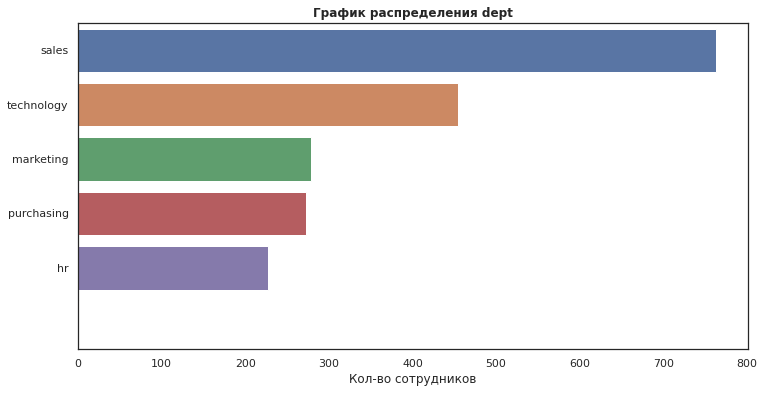

In [128]:
cat_vis(test_quit_features_df, 'dept')

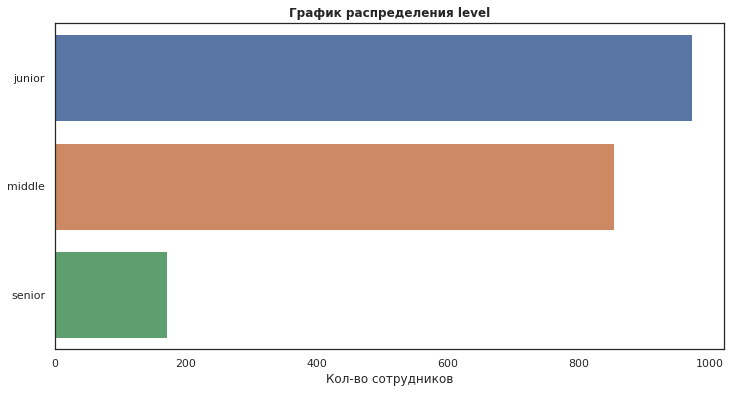

In [129]:
cat_vis(test_quit_features_df, 'level')

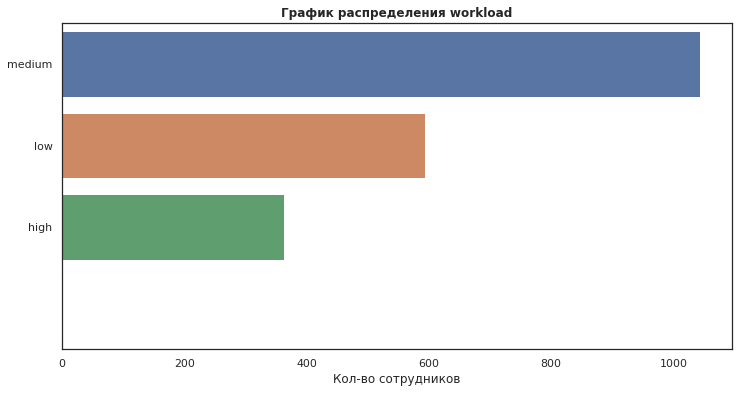

In [130]:
cat_vis(test_quit_features_df, 'workload')

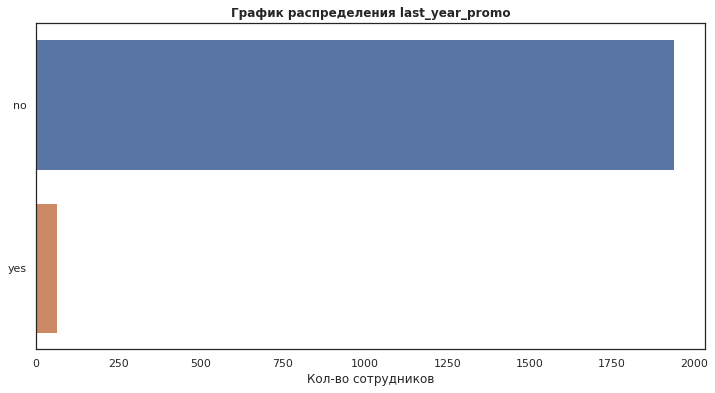

In [131]:
cat_vis(test_quit_features_df, 'last_year_promo')

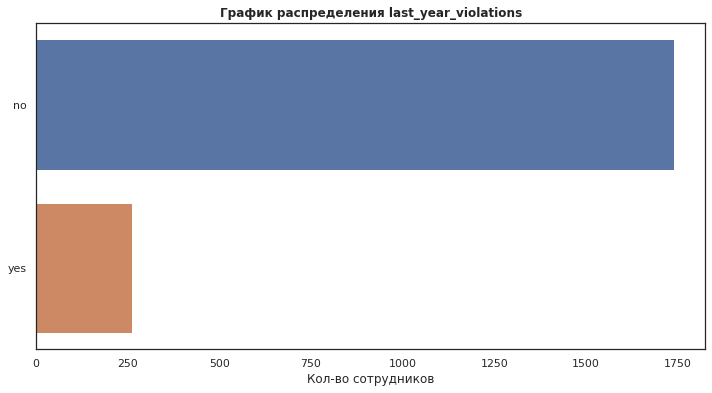

In [132]:
cat_vis(test_quit_features_df, 'last_year_violations')

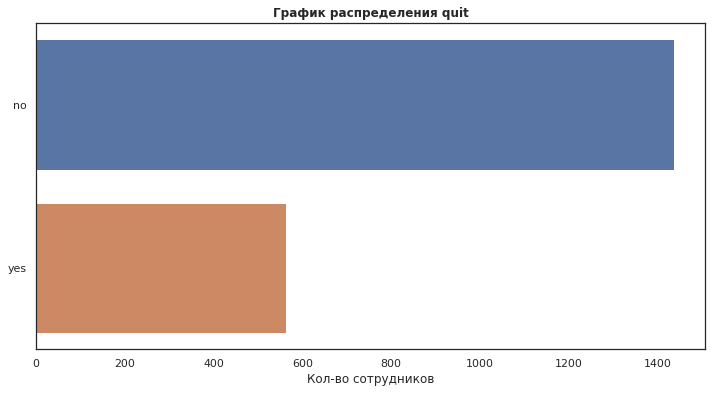

In [133]:
cat_vis(test_target_quit_df, 'quit')

#### Портрет уволившегося сотрудника.

In [134]:
train_quit_df.drop(columns='id').pivot_table(index='quit', aggfunc='median')

,employment_years,salary,supervisor_evaluation
quit,,,
no,4,34800,4
yes,1,22800,3


- Медианная оценка уволившихся меньше чем у оставшихся сотрудников.
- Уволившиеся сотрудники в работают 1 год в компании.
- Медианная зарплата у уволившихся ниже чем у оставшихся.

In [135]:
dept_quit_pt = train_quit_df.drop(columns='id').pivot_table(index='dept', columns='quit', aggfunc='count')['salary']
dept_quit_pt

quit,no,yes
dept,,
hr,348,116
marketing,419,163
purchasing,422,166
sales,1031,407
technology,652,276


In [136]:
dept_quit_pt.columns

Index(['no', 'yes'], dtype='object', name='quit')

In [137]:
dept_quit_pt['ratio'] = dept_quit_pt['yes']/dept_quit_pt['no']
dept_quit_pt

quit,no,yes,ratio
dept,,,
hr,348,116,0.333333
marketing,419,163,0.389021
purchasing,422,166,0.393365
sales,1031,407,0.394762
technology,652,276,0.423313


По соотношению меньше всего уволившихся в `hr`, а более всего в отделе `technology`.

In [138]:
promo_quit_pt = (train_quit_df.drop(columns='id').
 pivot_table(index='dept', columns=['last_year_promo', 'quit'], aggfunc='count')['salary'])
promo_quit_pt

last_year_promo     no          yes     
quit                no    yes    no  yes
dept                                    
hr               337.0  116.0  11.0  NaN
marketing        399.0  163.0  20.0  NaN
purchasing       408.0  166.0  14.0  NaN
sales            996.0  406.0  35.0  1.0
technology       620.0  276.0  32.0  NaN

In [139]:
promo_quit_pt['ratio'] =  promo_quit_pt[( 'no',  'yes')] / promo_quit_pt[( 'no',  'no')]

In [140]:
promo_quit_pt

last_year_promo     no          yes          ratio
quit                no    yes    no  yes          
dept                                              
hr               337.0  116.0  11.0  NaN  0.344214
marketing        399.0  163.0  20.0  NaN  0.408521
purchasing       408.0  166.0  14.0  NaN  0.406863
sales            996.0  406.0  35.0  1.0  0.407631
technology       620.0  276.0  32.0  NaN  0.445161

In [141]:
train_quit_df.loc[(train_quit_df['last_year_promo'] == 'yes') & (train_quit_df['dept'] == 'sales') & 
                  (train_quit_df['quit'] == 'yes')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3531,791500,sales,middle,low,6,yes,no,3,27600,yes


In [142]:
dept_workload_pt = (train_quit_df.drop(columns='id').
 pivot_table(index=['workload', 'dept'], columns='quit',  aggfunc='count')['salary'])
dept_workload_pt

quit                  no  yes
workload dept                
high     hr           66    7
         marketing    89   20
         purchasing   71   21
         sales       208   43
         technology  119   30
low      hr           78   65
         marketing   102   71
         purchasing   98   75
         sales       246  187
         technology  165  121
medium   hr          204   44
         marketing   228   72
         purchasing  253   70
         sales       577  177
         technology  368  125

In [143]:
dept_workload_pt['ratio'] = dept_workload_pt['yes'] / dept_workload_pt['no']

In [144]:
dept_workload_pt

quit                  no  yes     ratio
workload dept                          
high     hr           66    7  0.106061
         marketing    89   20  0.224719
         purchasing   71   21  0.295775
         sales       208   43  0.206731
         technology  119   30  0.252101
low      hr           78   65  0.833333
         marketing   102   71  0.696078
         purchasing   98   75  0.765306
         sales       246  187  0.760163
         technology  165  121  0.733333
medium   hr          204   44  0.215686
         marketing   228   72  0.315789
         purchasing  253   70  0.276680
         sales       577  177  0.306759
         technology  368  125  0.339674

In [145]:
dept_salary_pt = (train_quit_df.drop(columns='id').
 pivot_table(index=['dept', 'level', 'workload'], columns='quit', values='salary', aggfunc=('median', 'count')))

In [146]:
dept_salary_pt['ratio'] = round(dept_salary_pt[('count', 'yes')] / dept_salary_pt[('count', 'no')], 2)
dept_salary_pt

count          median          ratio
quit                           no    yes       no      yes      
dept       level  workload                                      
hr         junior high        5.0    6.0  40800.0  38400.0  1.20
                  low        27.0   51.0  19200.0  15600.0  1.89
                  medium     87.0   43.0  26400.0  25200.0  0.49
           middle high       45.0    1.0  55200.0  62400.0  0.02
                  low        44.0   14.0  25200.0  24000.0  0.32
                  medium    100.0    NaN  40800.0      NaN   NaN
           senior high       16.0    NaN  74400.0      NaN   NaN
                  low         7.0    NaN  32400.0      NaN   NaN
                  medium     17.0    1.0  55200.0  60000.0  0.06
marketing  junior high        7.0   18.0  38400.0  36000.0  2.57
                  low        34.0   61.0  18000.0  14400.0  1.79
                  medium     93.0   69.0  28800.0  26400.0  0.74
           middle high       57.0    2.0  57600.0  57000.0  0.04
                  low        64.0    9.0  25200.0  24000.0  0.14
                  medium    115.0    3.0  42000.0  46800.0  0.03
           senior high       25.0    NaN  75600.0      NaN   NaN
                  low         4.0    1.0  33600.0  26400.0  0.25
                  medium     20.0    NaN  55200.0      NaN   NaN
purchasing junior high        3.0   17.0  38400.0  34800.0  5.67
                  low        40.0   64.0  19200.0  15600.0  1.60
                  medium    102.0   62.0  26400.0  23400.0  0.61
           middle high       49.0    4.0  54000.0  48000.0  0.08
                  low        51.0    7.0  24000.0  22800.0  0.14
                  medium    119.0    6.0  38400.0  43200.0  0.05
           senior high       19.0    NaN  73200.0      NaN   NaN
                  low         7.0    4.0  32400.0  28800.0  0.57
                  medium     32.0    2.0  51600.0  52800.0  0.06
sales      junior high       21.0   29.0  34800.0  32400.0  1.38
                  low        74.0  168.0  18000.0  14400.0  2.27
                  medium    237.0  170.0  25200.0  24000.0  0.72
           middle high      148.0   13.0  52800.0  48000.0  0.09
                  low       156.0   17.0  24000.0  22800.0  0.11
                  medium    280.0    6.0  38400.0  36000.0  0.02
           senior high       39.0    1.0  69600.0  66000.0  0.03
                  low        16.0    2.0  37200.0  31800.0  0.12
                  medium     60.0    1.0  51600.0  46800.0  0.02
technology junior high        8.0   28.0  43800.0  42600.0  3.50
                  low        46.0  100.0  19200.0  19200.0  2.17
                  medium    162.0  117.0  31200.0  30000.0  0.72
           middle high       85.0    NaN  62400.0      NaN   NaN
                  low       110.0   19.0  28200.0  27600.0  0.17
                  medium    163.0    7.0  45600.0  45600.0  0.04
           senior high       26.0    2.0  85800.0  79200.0  0.08
                  low         9.0    2.0  39600.0  38400.0  0.22
                  medium     43.0    1.0  61200.0  69600.0  0.02

Вероятнее всего уволится сотрудник, у которого следующие прзнаки:
1. Работает менее 1 года.
2. С медианной оценкой супервайзера менне 3.
3. С зарплатой ниже медианной по отделу.
4. Уровень занимаемой позиции junior с высокой загрузкой.

In [147]:
pred_y_df = pd.DataFrame(pred_y)

In [148]:
pred_quit_df = test_target_quit_df.sort_values(by='id').copy()
pred_quit_df['jsr_pred_y'] = pred_y
pred_quit_df.head()

,id,quit,jsr_pred_y
1566,100298,no,0.850000
491,100480,no,0.852000
802,100503,no,0.790000
725,100610,no,0.813333
319,100692,no,0.693333


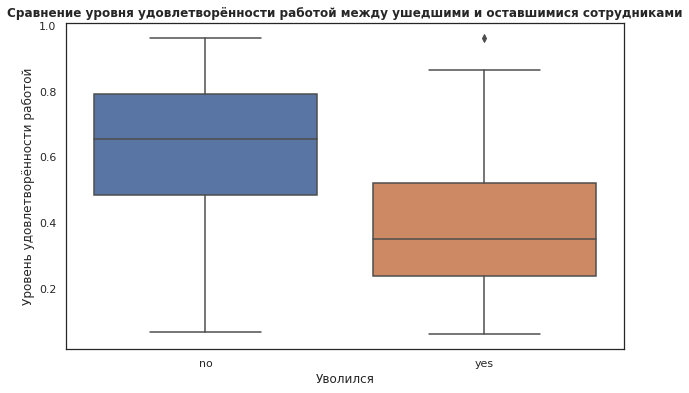

In [149]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pred_quit_df, x='quit', y='jsr_pred_y')
plt.title('Сравнение уровня удовлетворённости работой между ушедшими и оставшимися сотрудниками', weight='bold')
plt.xlabel('Уволился')
plt.ylabel('Уровень удовлетворённости работой')
plt.show()

Боксплот подверждает утверждение аналитиков, что уровень удовлетворенности влияет на склонность сотрудника к увольнению.
Однако, можно заметить аномалию в предсказаниях, когда сотрудник с высоким уровнем удовлетворенности уволился.

H0: Средний уровень удовлетворенности сотрудников среди ушедших и оставшихся равен.

H1: Средний уровень удовлетворенности сотрудников среди ушедших и оставшихся различается.

In [150]:
quit_group = pred_quit_df[pred_quit_df['quit'] == 'yes']['jsr_pred_y']
stay_group = pred_quit_df[pred_quit_df['quit'] == 'no']['jsr_pred_y']

In [151]:
t_stat, p_value = stats.ttest_ind(quit_group, stay_group, equal_var=False)

alpha = 0.05

print(f't-статистика: {t_stat}, p-значение: {p_value}')

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

t-статистика: -22.76610561471403, p-значение: 4.177988026712143e-94
Отвергаем нулевую гипотезу


### Добавление нового входного признака

In [152]:
train_quit_df.sort_values(by='id', inplace=True)
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2455,100469,marketing,junior,medium,1,no,no,4,28800,no
1592,100601,technology,middle,high,4,no,no,4,68400,no
2657,100858,sales,junior,medium,2,no,no,4,25200,yes


In [153]:
train_quit_df['salary_category'] = train_quit_df['salary'].apply(salary_categorization, args=(73800,))
test_quit_features_df['salary_category'] = test_quit_features_df['salary'].apply(salary_categorization, args=(73800,))

In [154]:
train_quit_df['log_salary'] = np.log1p(train_quit_df['salary'])
test_quit_features_df['log_salary'] = np.log1p(test_quit_features_df['salary'])

In [155]:
pred_jsr = best_model.predict(train_quit_df.drop(['id', 'quit'], axis=1))
pred_jsr

array([0.34571429, 0.31166667, 0.64307692, ..., 0.082     , 0.76428571,
       0.29428571])

In [156]:
train_quit_df['jsr'] = pred_jsr
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_category,log_salary,jsr
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,1 группа,9.923339,0.345714
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,1 группа,9.980495,0.311667
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,1 группа,10.268165,0.643077
1592,100601,technology,middle,high,4,no,no,4,68400,no,2 группа,11.133143,0.675714
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,1 группа,10.134639,0.825714


In [157]:
pred_test_jsr = best_model.predict(test_quit_features_df.drop(['id'], axis=1))

In [158]:
pred_test_jsr

array([0.85      , 0.852     , 0.79      , ..., 0.48888889, 0.46333333,
       0.30714286])

In [159]:
test_quit_features_df['jsr'] = pred_test_jsr
test_quit_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,salary_category,log_salary,jsr
1172,100298,hr,junior,low,2,no,no,4,19200,1 группа,9.862718,0.850000
852,100480,marketing,junior,low,4,no,no,4,16800,1 группа,9.729194,0.852000
848,100503,purchasing,middle,high,5,no,no,4,55200,2 группа,10.918736,0.790000
524,100610,sales,middle,medium,5,no,no,4,43200,2 группа,10.673619,0.813333
476,100692,sales,middle,high,6,no,no,4,48000,2 группа,10.778977,0.693333


### Подготовка данных

In [160]:
num_columns_quit = ['employment_years', 'salary', 'jsr', 'log_salary']

In [161]:
param_grid_quit = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 10),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 50, 2),
        'preprocessor__num': ['passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'models__gamma': [0.01, 0.1, 1, 10, 100],
        'models__kernel': ['linear'],
        'models__degree': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }
] 

In [162]:
#сбор кодировщиков и скейлеров
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
) 

In [163]:
#финальный пайплайн
pipe_final_quit = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [164]:
rndscv_2 = RandomizedSearchCV(
    estimator=pipe_final_quit,
    param_distributions=param_grid_quit,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

In [165]:
X_train_quit = train_quit_df.drop(columns=['id', 'quit'])
X_test_quit = test_quit_features_df.drop(columns='id')
y_train_quit = train_quit_df['quit']
y_test_quit = test_target_quit_df['quit']

In [166]:
label_encoder = LabelEncoder()
y_train_quit_labeled = label_encoder.fit_transform(y_train_quit)
y_test_quit_labeled = label_encoder.transform(y_test_quit) 

### Проверка работы модели

In [167]:
rndscv_2.fit(X_train_quit, y_train_quit_labeled)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_ohe',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                                        random_state=15)],
                                         'models__C': [0.01, 0.1, 1, 10, 100],
                                         'models__degree': range(2, 10),
                                         'models__gamma': [0.01, 0.1, 1, 10,
                                                           100],
                                         'models__kernel': ['linear'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]},
                                        {'models': [LogisticRegression(random_state=15)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   random_state=15, scoring='roc_auc')

In [168]:
pd.DataFrame(rndscv_2.cv_results_).sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__kernel,param_models__gamma,param_models__degree,param_models__C,param_models,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.032882,0.000723,0.013953,0.000168,passthrough,NaN,NaN,NaN,NaN,DecisionTreeClassifier(random_state=15),2.0,9.0,11.0,"{'preprocessor__num': 'passthrough', 'models__...",0.932098,0.943900,0.924956,0.921461,0.936939,0.931871,0.008082,1
1,0.034639,0.001077,0.014783,0.000526,passthrough,NaN,NaN,NaN,NaN,DecisionTreeClassifier(random_state=15),2.0,7.0,19.0,"{'preprocessor__num': 'passthrough', 'models__...",0.931377,0.942852,0.920308,0.921519,0.935888,0.930389,0.008566,2
7,0.032583,0.000572,0.014057,0.000181,passthrough,NaN,NaN,NaN,NaN,DecisionTreeClassifier(random_state=15),4.0,11.0,9.0,"{'preprocessor__num': 'passthrough', 'models__...",0.922701,0.945392,0.924050,0.921117,0.936414,0.929935,0.009440,3
9,0.033000,0.000447,0.014660,0.000795,passthrough,NaN,NaN,NaN,NaN,DecisionTreeClassifier(random_state=15),2.0,11.0,12.0,"{'preprocessor__num': 'passthrough', 'models__...",0.921445,0.945473,0.922273,0.921994,0.936039,0.929445,0.009709,4
2,0.900772,0.014246,0.035791,0.001132,StandardScaler(),linear,1.0,6.0,1.0,"SVC(probability=True, random_state=15)",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.923198,0.925885,0.908648,0.914006,0.903714,0.915090,0.008419,5


In [169]:
best_model_quit = rndscv_2.best_estimator_
pred_y_quit = best_model_quit.predict(test_quit_features_df.drop(columns='id'))
pred_y_prob_quit = best_model_quit.predict_proba(test_quit_features_df.drop(columns='id'))[:,1]
pred_y_quit

array([0, 0, 0, ..., 1, 0, 1])

In [170]:
roc_auc = round(roc_auc_score(y_test_quit_labeled, pred_y_prob_quit), 3)
roc_auc

0.924

In [171]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(X_train_quit, y_train_quit_labeled)

DummyClassifier(random_state=15, strategy='stratified')

In [172]:
dummy_pred_y = dummy_model.predict_proba(X_test_quit)[:, 1]
roc_auc_dummy = round(roc_auc_score(y_test_quit_labeled, dummy_pred_y), 3)
roc_auc_dummy

0.494

In [173]:
feature_names_quit = best_model_quit.named_steps['preprocessor'].get_feature_names_out()

In [174]:
feature_importances_quit = pd.DataFrame(
    {
        'Feature': feature_names_quit,
        'Importance': best_model_quit.named_steps['models'].feature_importances_
    }) 

In [175]:
feature_importances_quit.sort_values(by='Importance', ascending=False)

,Feature,Importance
11,num__jsr,0.404368
6,ord__level,0.354931
7,ord__workload,0.083276
12,num__log_salary,0.071722
9,num__employment_years,0.060633
10,num__salary,0.010796
13,remainder__supervisor_evaluation,0.006794
2,ohe__dept_sales,0.003169
8,ord__salary_category,0.001566
1,ohe__dept_purchasing,0.001478


In [176]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train_quit),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test_quit),
    columns=data_preprocessor.get_feature_names_out()    
)
X_train_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,ord__salary_category,num__employment_years,num__salary,num__jsr,num__log_salary,remainder__supervisor_evaluation
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.276014,-0.884841,-0.891779,-0.932793,2.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.276014,-0.805636,-1.049489,-0.802552,3.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.062941,-0.330404,0.485623,-0.147039,4.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.117449,2.283367,0.636801,1.823980,4.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.669477,-0.568020,1.331611,-0.451305,4.0


In [177]:
best_model_quit.named_steps['models']

DecisionTreeClassifier(max_depth=11, min_samples_leaf=9, random_state=15)

In [178]:
roc_auc_scores = {}


for i in range(len(X_train_p.columns)):

    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_p, y_train_quit_labeled)
    
    features_names = selector.get_feature_names_out()
    
    X_train_new = X_train_p[list(features_names)]
    X_test_new = X_test_p[list(features_names)]

    best_model = best_model_quit.named_steps['models']
    best_model.fit(X_train_new, y_train_quit_labeled)

    roc_auc = roc_auc_score(y_test_quit_labeled, best_model.predict_proba(X_test_new)[:,1])
    roc_auc_scores[i+1] = round(roc_auc, 3)

In [179]:
dict(sorted(roc_auc_scores.items(), key=lambda item: item[1], reverse=True))

{12: 0.926,
 13: 0.925,
 9: 0.924,
 10: 0.924,
 11: 0.924,
 14: 0.924,
 4: 0.92,
 5: 0.92,
 6: 0.92,
 7: 0.92,
 8: 0.92,
 3: 0.905,
 2: 0.903,
 1: 0.876}

In [180]:
selector = SelectKBest(mutual_info_classif, k=11)
selector.fit(X_train_p, y_train_quit_labeled)
selected_indices = selector.get_support(indices=True)
kbest_features_importance = selector.scores_

In [181]:
feature_importances_quit_1 = pd.DataFrame(
    {
        'kbest_feature': X_train_p.columns[selected_indices],
        'importance': kbest_features_importance[selected_indices]
    }) 

feature_importances_quit_1.sort_values(by='importance', ascending=False)

,kbest_feature,importance
8,num__jsr,0.290593
3,ord__level,0.145719
6,num__employment_years,0.144689
7,num__salary,0.140976
9,num__log_salary,0.131441
5,ord__salary_category,0.088468
10,remainder__supervisor_evaluation,0.050894
4,ord__workload,0.022010
1,ohe__dept_technology,0.011138
2,ohe__last_year_violations_yes,0.007582


### Промежуточный вывод

- Лучшая модель DecisionTreeClassifier(max_depth=6, min_samples_leaf=23, random_state=15)
- Метрика ROC-AUC до отбора признаков: 0.924
- Метрика ROC-AUC после отбора признаков: 0.926
- Отобранные признаки:

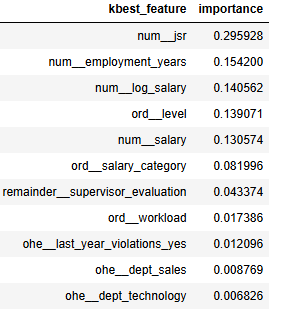

### Общий вывод

Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Исходные данные:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

С данными были проведены следующие работы:
1. Поиск явных и неявынх дубликатов.
2. Заполнение пробелов и пропусков. 

-----

Для поиска лучшей модели и ее параметров для решения первой задачи я выбрал метод создания пайплайна и перебор методом RandomizedSearchCV. Для определения лучшей использовалась кастомная метрики SMAPE.

- Лучшая модель DecisionTreeRegressor(max_depth=19, min_samples_leaf=5, random_state=15).
- SMAPE = 13.34.
- Тройка самых выжных признаков supervisor_evaluation, employment_years и last_year_violations.
- Основная модель показывает лучший результат (13.34) по сравнению с базовой (38.22). Тест на адекватность пройден.

Важность признаков:

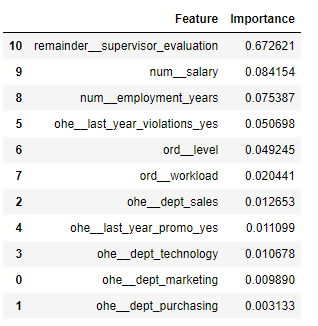

Для поиска лучшей модели и ее параметров для решения второй задачи я выбрал метод создания пайплайна и перебор методом RandomSearchCV. Для определения лучшей использовалась метрики ROC-AUC.

- Лучшая модель DecisionTreeClassifier(max_depth=6, min_samples_leaf=23, random_state=15)
- Метрика ROC-AUC до отбора признаков: 0.924
- Метрика ROC-AUC после отбора признаков: 0.926
- Основная модель показывает лучший результат (0.924) по сравнению с базовой (0.494).

Важность признаков после отбора:

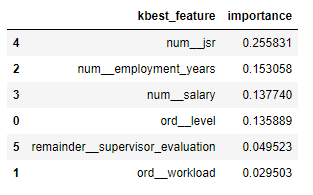


**Рекомендации:**

Бизнесу стоит обратить внимание на следующих сотрудников:

1. Работает менее 1 года.
2. С медианной оценкой супервайзера менне 3.
3. С зарплатой ниже медианной по отделу.
4. Уровень занимаемой позиции junior с высокой загрузкой.

Что делать:

1. Проводить периодически оценку удоволетворенности сотрудников.
2. Следить за уровнем заработной платы.
3. Следить за уровнем нагрузки сотрудника.

[Вернуться в начало тетрадки](#head)